In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

In [2]:
class GMM:
    """ Gaussian Mixture Model
    """

    def __init__(self, n_clusters, max_iter=100, tol=1e-3, random_state=None):
        self.n_clusters = n_clusters  # number of Guassians/clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def get_params(self):
        return self.pi, self.mu, self.sigma

    def _calculate_mean_covariance(self, X, Y):
        """ Calculate mean and covariance of each Gaussian cluster initialized using k-means prediction
        """
        n_rows = X.shape[0] # number of data points
        n_features = X.shape[1] # dimension of data
        idx = [[] for _ in range(self.n_clusters)] # group data points of each cluster
        initial_pi = np.zeros(self.n_clusters)
        initial_means = np.zeros((self.n_clusters, n_features))
        initial_cov = np.zeros((self.n_clusters, n_features, n_features))
        
        for i in range(n_rows):
            idx[Y[i]].append(i)

        for k in range(self.n_clusters):
            X_k = X[idx[k]]
            n_rows_k = X_k.shape[0]  # number of data points in current Gaussian
            initial_pi[k] = n_rows_k / n_rows
            initial_means[k] = np.mean(X_k, axis=0)
            de_meaned = X_k - initial_means[k]
            initial_cov[k] = np.dot(initial_pi[k] * de_meaned.T, de_meaned) / n_rows_k
        
        assert np.sum(initial_pi) == 1

        return initial_pi, initial_means, initial_cov

    def _initialise_parameters(self, X):
        """ Implement k-means to find initial parameter values
        """
        kmeans = KMeans(n_clusters=self.n_clusters, init='k-means++', max_iter=500, algorithm='auto', random_state=self.random_state).fit(X)
        Y = kmeans.predict(X)
        
        return self._calculate_mean_covariance(X, Y)

    def _e_step(self, X):
        """ Perform E-step on GMM model
        """
        n_rows = X.shape[0] # number of data points
        self.gamma = np.zeros((n_rows, self.n_clusters))

        for c in range(self.n_clusters):
            # Posterior Distribution using Bayes Rule
            self.gamma[:, c] = self.pi[c] * multivariate_normal.pdf(X, self.mu[c], self.sigma[c], allow_singular=True)

        # normalize across columns to make a valid probability
        gamma_norm = np.sum(self.gamma, axis=1)[:, np.newaxis]
        self.gamma /= gamma_norm

        return self.gamma

    def _m_step(self, X):
        """ Perform M-step of the GMM
        We need to update prior, mean and covariance matrix for each cluster.
        """
        self.pi = np.mean(self.gamma, axis=0) # responsibilities for each Gaussian
        self.mu = np.dot(self.gamma.T, X) / np.sum(self.gamma, axis=0)[:, np.newaxis]

        for c in range(self.n_clusters):
            x = X - self.mu[c]
            gamma_diag = np.diag(self.gamma[:, c])
            x_mu = np.matrix(x)
            gamma_diag = np.matrix(gamma_diag)
            sigma_c = x.T * gamma_diag * x
            self.sigma[c] = (sigma_c) / np.sum(self.gamma, axis=0)[:, np.newaxis][c]

        return self.pi, self.mu, self.sigma

    def _compute_log_likelihood(self, X):
        """ Compute log likelihood
        """
        n_rows = X.shape[0] # number of data points
        log_likelihood = np.zeros((n_rows, self.n_clusters))

        for c in range(self.n_clusters):
            dist = multivariate_normal(self.mu[c], self.sigma[c], allow_singular=True)
            log_likelihood[:, c] = np.log(self.pi[c]) + dist.logpdf(X)
        
        log_likelihood = np.sum(log_likelihood)
        
        return log_likelihood

    def fit(self, X):
        """ Compute E-step and M-step and calculate the log likelihood
        """
        self.pi, self.mu, self.sigma = self._initialise_parameters(X)
        log_likelihood_prev = 0

        try:
            for run in range(self.max_iter):
                self.gamma = self._e_step(X)
                self.pi, self.mu, self.sigma = self._m_step(X)
                log_likelihood = self._compute_log_likelihood(X)

                if run % 5 == 0:
                    print('Iteration: %d, log likelihood: %0.6f' % (run, log_likelihood))
                    
                if abs(log_likelihood - log_likelihood_prev) < self.tol:
                    break
                
                log_likelihood_prev = log_likelihood

        except Exception as e:
            print(e)

        return self

    def predict(self, X):
        """ Return predicted ks using Bayes rule to calculate the posterior distribution
        """
        ks = np.zeros((X.shape[0], self.n_clusters))

        for c in range(self.n_clusters):
            ks[:, c] = self.pi[c] * multivariate_normal.pdf(X, self.mu[c], self.sigma[c], allow_singular=True)

        ks = ks.argmax(1)
        
        return ks

    def predict_proba(self, X):
        """ Return posterior probabilities
        """
        post_proba = np.zeros((X.shape[0], self.n_clusters))

        for c in range(self.n_clusters):
            dist = multivariate_normal(self.mu[c], self.sigma[c], allow_singular=True)
            post_proba[:, c] = np.log(self.pi[c]) + dist.logpdf(X)

        return logsumexp(post_proba, axis=1)

In [3]:
class1 = pd.read_csv('data/Class1.txt',delimiter = ',',names = ['column1','column2'])
class2 = pd.read_csv('data/Class2.txt',delimiter = ',', names = ['column1','column2'])
class1['class'] = 0;
class2['class'] = 1;
result = pd.concat([class1, class2], axis=0)
result  = result.reset_index(drop=True)
Y = result['class']
X = result.drop('class', axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
XY_train = pd.concat([X_train, Y_train], axis=1)
X0_train = XY_train[XY_train['class'] == 0]
X1_train = XY_train[XY_train['class'] == 1]
X0_train = X0_train.drop('class', axis = 1)
X1_train = X1_train.drop('class', axis = 1)

In [4]:
gmm0 = GMM(n_clusters=2, max_iter=100, tol=1e-3).fit(np.array(X0_train))
gmm1 = GMM(n_clusters=2, max_iter=100, tol=1e-3).fit(np.array(X1_train))
score0 = gmm0.predict_proba(X_test)
score1 = gmm1.predict_proba(X_test)
Y_pred = [0 if score0[i] > score1[i] else 1 for i in range(len(X_test))]
print('Test accuracy: {} %'.format(accuracy_score(Y_test, Y_pred) * 100))
print('Confusion matrix:\n', confusion_matrix(Y_test, Y_pred))

Iteration: 0, log likelihood: -600448.823993
Iteration: 5, log likelihood: -847235.141047
Iteration: 0, log likelihood: -1257269.052384
Iteration: 5, log likelihood: -1266941.686870
Test accuracy: 100.0 %
Confusion matrix:
 [[399   0]
 [  0 401]]


[]

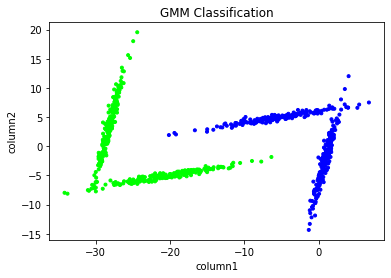

In [5]:
plt.title('GMM Classification')
plt.xlabel('column1')
plt.ylabel('column2')
plt.scatter(X_test['column1'], X_test['column2'], c=Y_pred, cmap=plt.cm.get_cmap('brg'),marker='.')
plt.plot()

In [6]:
class1 = pd.read_csv('nls_data/Class1.txt',delimiter = ',',names = ['column1','column2'])
class2 = pd.read_csv('nls_data/Class2.txt',delimiter = ',', names = ['column1','column2'])
class1['class'] = 0;
class2['class'] = 1;
result = pd.concat([class1, class2], axis=0)
result  = result.reset_index(drop=True)
Y = result['class']
X = result.drop('class', axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
XY_train = pd.concat([X_train, Y_train], axis=1)
X0_train = XY_train[XY_train['class'] == 0]
X1_train = XY_train[XY_train['class'] == 1]
X0_train = X0_train.drop('class', axis = 1)
X1_train = X1_train.drop('class', axis = 1)

In [7]:
gmm0 = GMM(n_clusters=2, max_iter=100, tol=1e-3).fit(np.array(X0_train))
gmm1 = GMM(n_clusters=2, max_iter=100, tol=1e-3).fit(np.array(X1_train))
score0 = gmm0.predict_proba(X_test)
score1 = gmm1.predict_proba(X_test)
Y_pred = [0 if score0[i] > score1[i] else 1 for i in range(len(X_test))]
print('Test accuracy: {} %'.format(accuracy_score(Y_test, Y_pred) * 100))
print('Confusion matrix:\n', confusion_matrix(Y_test, Y_pred))

Iteration: 0, log likelihood: -12367.898024
Iteration: 5, log likelihood: -16356.275453
Iteration: 10, log likelihood: -249881.908973
Iteration: 15, log likelihood: -249919.832063
Iteration: 0, log likelihood: -12545.533071
Iteration: 5, log likelihood: -14920.070302
Iteration: 10, log likelihood: -238861.317717
Iteration: 15, log likelihood: -238913.115091
Test accuracy: 100.0 %
Confusion matrix:
 [[205   0]
 [  0 195]]


[]

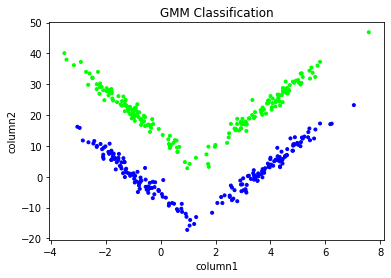

In [8]:
plt.title('GMM Classification')
plt.xlabel('column1')
plt.ylabel('column2')
plt.scatter(X_test['column1'], X_test['column2'], c=Y_pred, cmap=plt.cm.get_cmap('brg'),marker='.')
plt.plot()